In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import umap.umap_ as umap
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import colorcet
import seaborn as sns


import sklearn.metrics
import sklearn.neural_network
import sklearn.neighbors
import skimage.filters

/home/havivd/miniconda3/envs/WormholeTest/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_31018/3903442860.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
from wassersteinwormhole import Wormhole

2024-01-31 16:40:34.035114: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


# Load MNIST data

In [5]:


image_train = np.load('/path/to/MNIST/image_train.npy')
label_train = np.load('/path/to/MNIST/label_train.npy')
image_test = np.load('/path/to/MNIST/image_test.npy')
label_test = np.load('/path/to/MNIST/label_test.npy')


In [6]:
thresh = skimage.filters.threshold_otsu(image_train.reshape([-1]))

In [7]:
pc_train = [np.stack(np.where(image>thresh), axis = 1) for image in image_train]
pc_test = [np.stack(np.where(image>thresh), axis = 1) for image in image_test]


## Show some examples

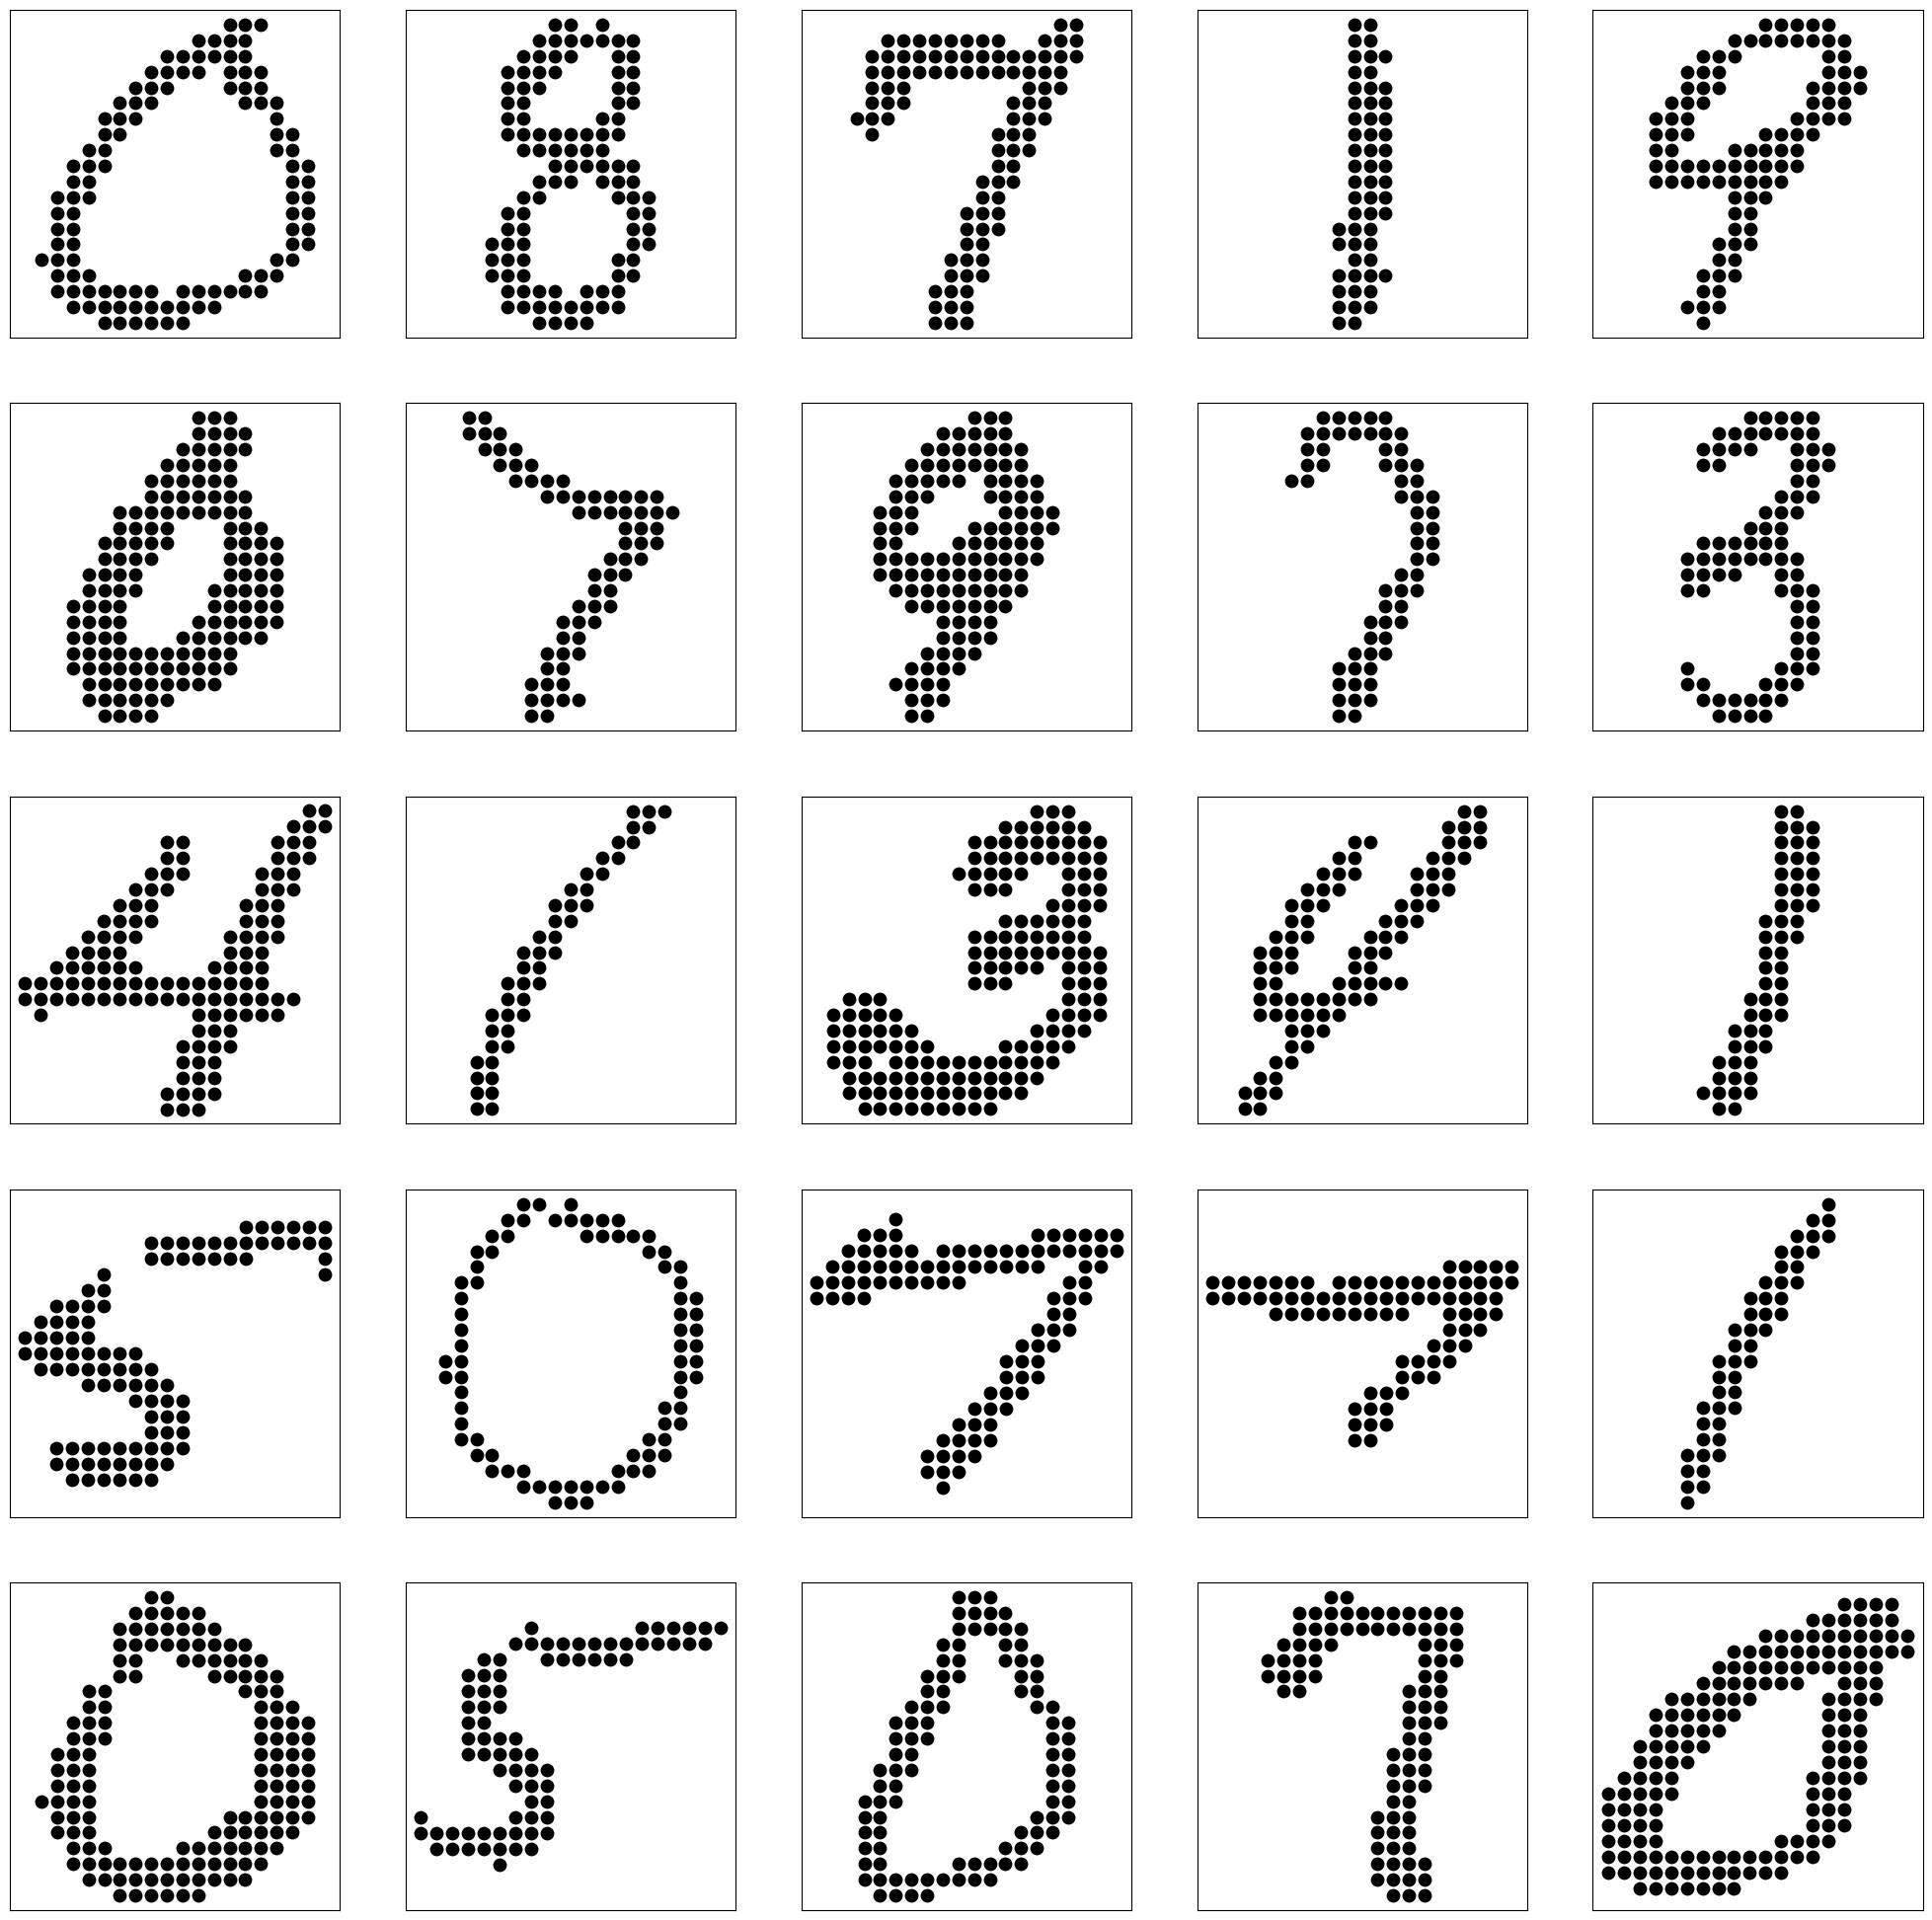

In [8]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(pc_train)))
    min_val =thresh
    
    plt.subplot(5,5,1+_)
    plt.scatter(pc_train[ind][:, 1], -pc_train[ind][:, 0], c = 'black', s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

# Or load your own set of point-clouds

In [ ]:
import pickle

with open('/data/peer/DoronHaviv/MNIST/pc_train.pickle', 'rb') as f:
    pc_train = pickle.load(f)

with open('/data/peer/DoronHaviv/MNIST/pc_test.pickle', 'rb') as f:
    pc_test = pickle.load(f)
    
label_train = np.load('/data/peer/DoronHaviv/MNIST/label_train.npy')
label_test = np.load('/data/peer/DoronHaviv/MNIST/label_test.npy')

# Wormhole Model

In [9]:
WormholeModel = Wormhole(point_clouds = pc_train, point_clouds_test = pc_test)

Using Calculated Min Max Scaling Values


## Train model

In [10]:
WormholeModel.train(epochs = 10000)

 enc_loss: 2.962e-05 dec_loss: 9.262e-04 enc_corr: 0.983: 100%|██████████| 10000/10000 [15:26<00:00, 10.79it/s]


### Save parameters

In [ ]:
with open('/path/to/savedmodel/WormholeModel.pickle', 'wb') as f:
    pickle.dump(WormholeModel.params, f)

## Load trained model

In [ ]:
with open('/path/to/savedmodel/WormholeModel.pickle',, 'rb') as f:
    WormholeModel.params = pickle.load(f)

# Generate encodings

In [11]:
train_encodings = WormholeModel.encode(WormholeModel.point_clouds, WormholeModel.masks)
test_encodings = WormholeModel.encode(WormholeModel.point_clouds_test, WormholeModel.masks_test)

## Compare to true Wasserstein distance

### Train

In [12]:
train_rand_ind = np.random.choice(np.arange(train_encodings.shape[0]), 128,replace = False)
upper_traingular_ind = np.stack(np.triu_indices(train_rand_ind.shape[0], 1), axis = 1) 

true_w2 = np.asarray(WormholeModel.jit_dist_enc([WormholeModel.point_clouds[train_rand_ind][upper_traingular_ind[:, 0]], 
                                                 WormholeModel.masks_normalized[train_rand_ind][upper_traingular_ind[:, 0]]], 
                                                [WormholeModel.point_clouds[train_rand_ind][upper_traingular_ind[:, 1]], 
                                                 WormholeModel.masks_normalized[train_rand_ind][upper_traingular_ind[:, 1]]], 
                                                 WormholeModel.eps_enc, WormholeModel.lse_enc)) 

enc_L2 = np.mean(np.square(train_encodings[train_rand_ind][upper_traingular_ind[:, 0]] - train_encodings[train_rand_ind][upper_traingular_ind[:, 1]]), axis = -1)

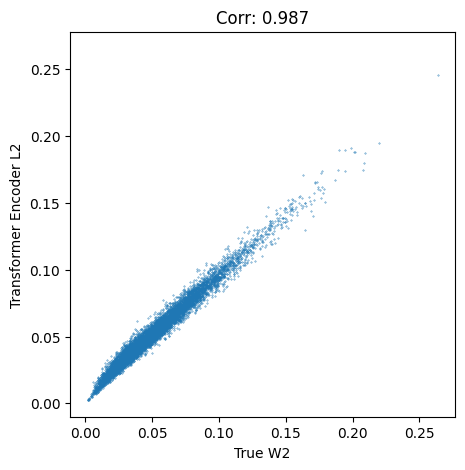

In [13]:
plt.figure(figsize = (5,5))
plt.scatter(true_w2, enc_L2, s = 0.1)
plt.axis('square')
plt.xlabel('True W2')
plt.ylabel('Transformer Encoder L2')
plt.title('Corr: ' + str(np.round(scipy.stats.pearsonr(true_w2, enc_L2)[0],3)))
plt.show()

### Test

In [31]:
test_rand_ind = np.random.choice(np.arange(test_encodings.shape[0]), 128,replace = False)
upper_traingular_ind = np.stack(np.triu_indices(test_rand_ind.shape[0], 1), axis = 1) 

true_w2 = np.asarray(WormholeModel.jit_dist_enc([WormholeModel.point_clouds_test[test_rand_ind][upper_traingular_ind[:, 0]], 
                                                 WormholeModel.masks_test_normalized[test_rand_ind][upper_traingular_ind[:, 0]]], 
                                                [WormholeModel.point_clouds_test[test_rand_ind][upper_traingular_ind[:, 1]], 
                                                 WormholeModel.masks_test_normalized[test_rand_ind][upper_traingular_ind[:, 1]]], 
                                                 WormholeModel.eps_enc, WormholeModel.lse_enc)) 

enc_L2 = np.mean(np.square(test_encodings[test_rand_ind][upper_traingular_ind[:, 0]] - test_encodings[test_rand_ind][upper_traingular_ind[:, 1]]), axis = -1)

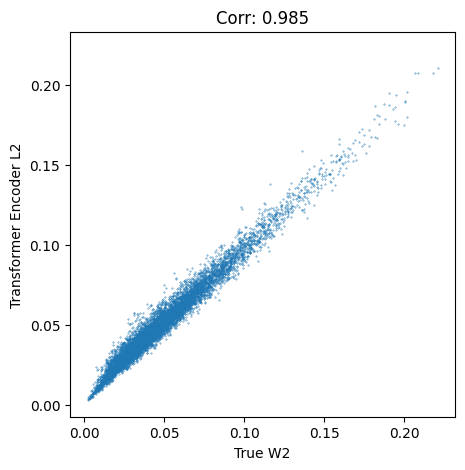

In [32]:
plt.figure(figsize = (5,5))
plt.scatter(true_w2, enc_L2, s = 0.1)
plt.axis('square')
plt.xlabel('True W2')
plt.ylabel('Transformer Encoder L2')
plt.title('Corr: ' + str(np.round(scipy.stats.pearsonr(true_w2, enc_L2)[0],3)))
plt.show()

#  Decodings

In [16]:
train_decodings = WormholeModel.decode(train_encodings)
test_decodings = WormholeModel.decode(test_encodings)

## Plot train

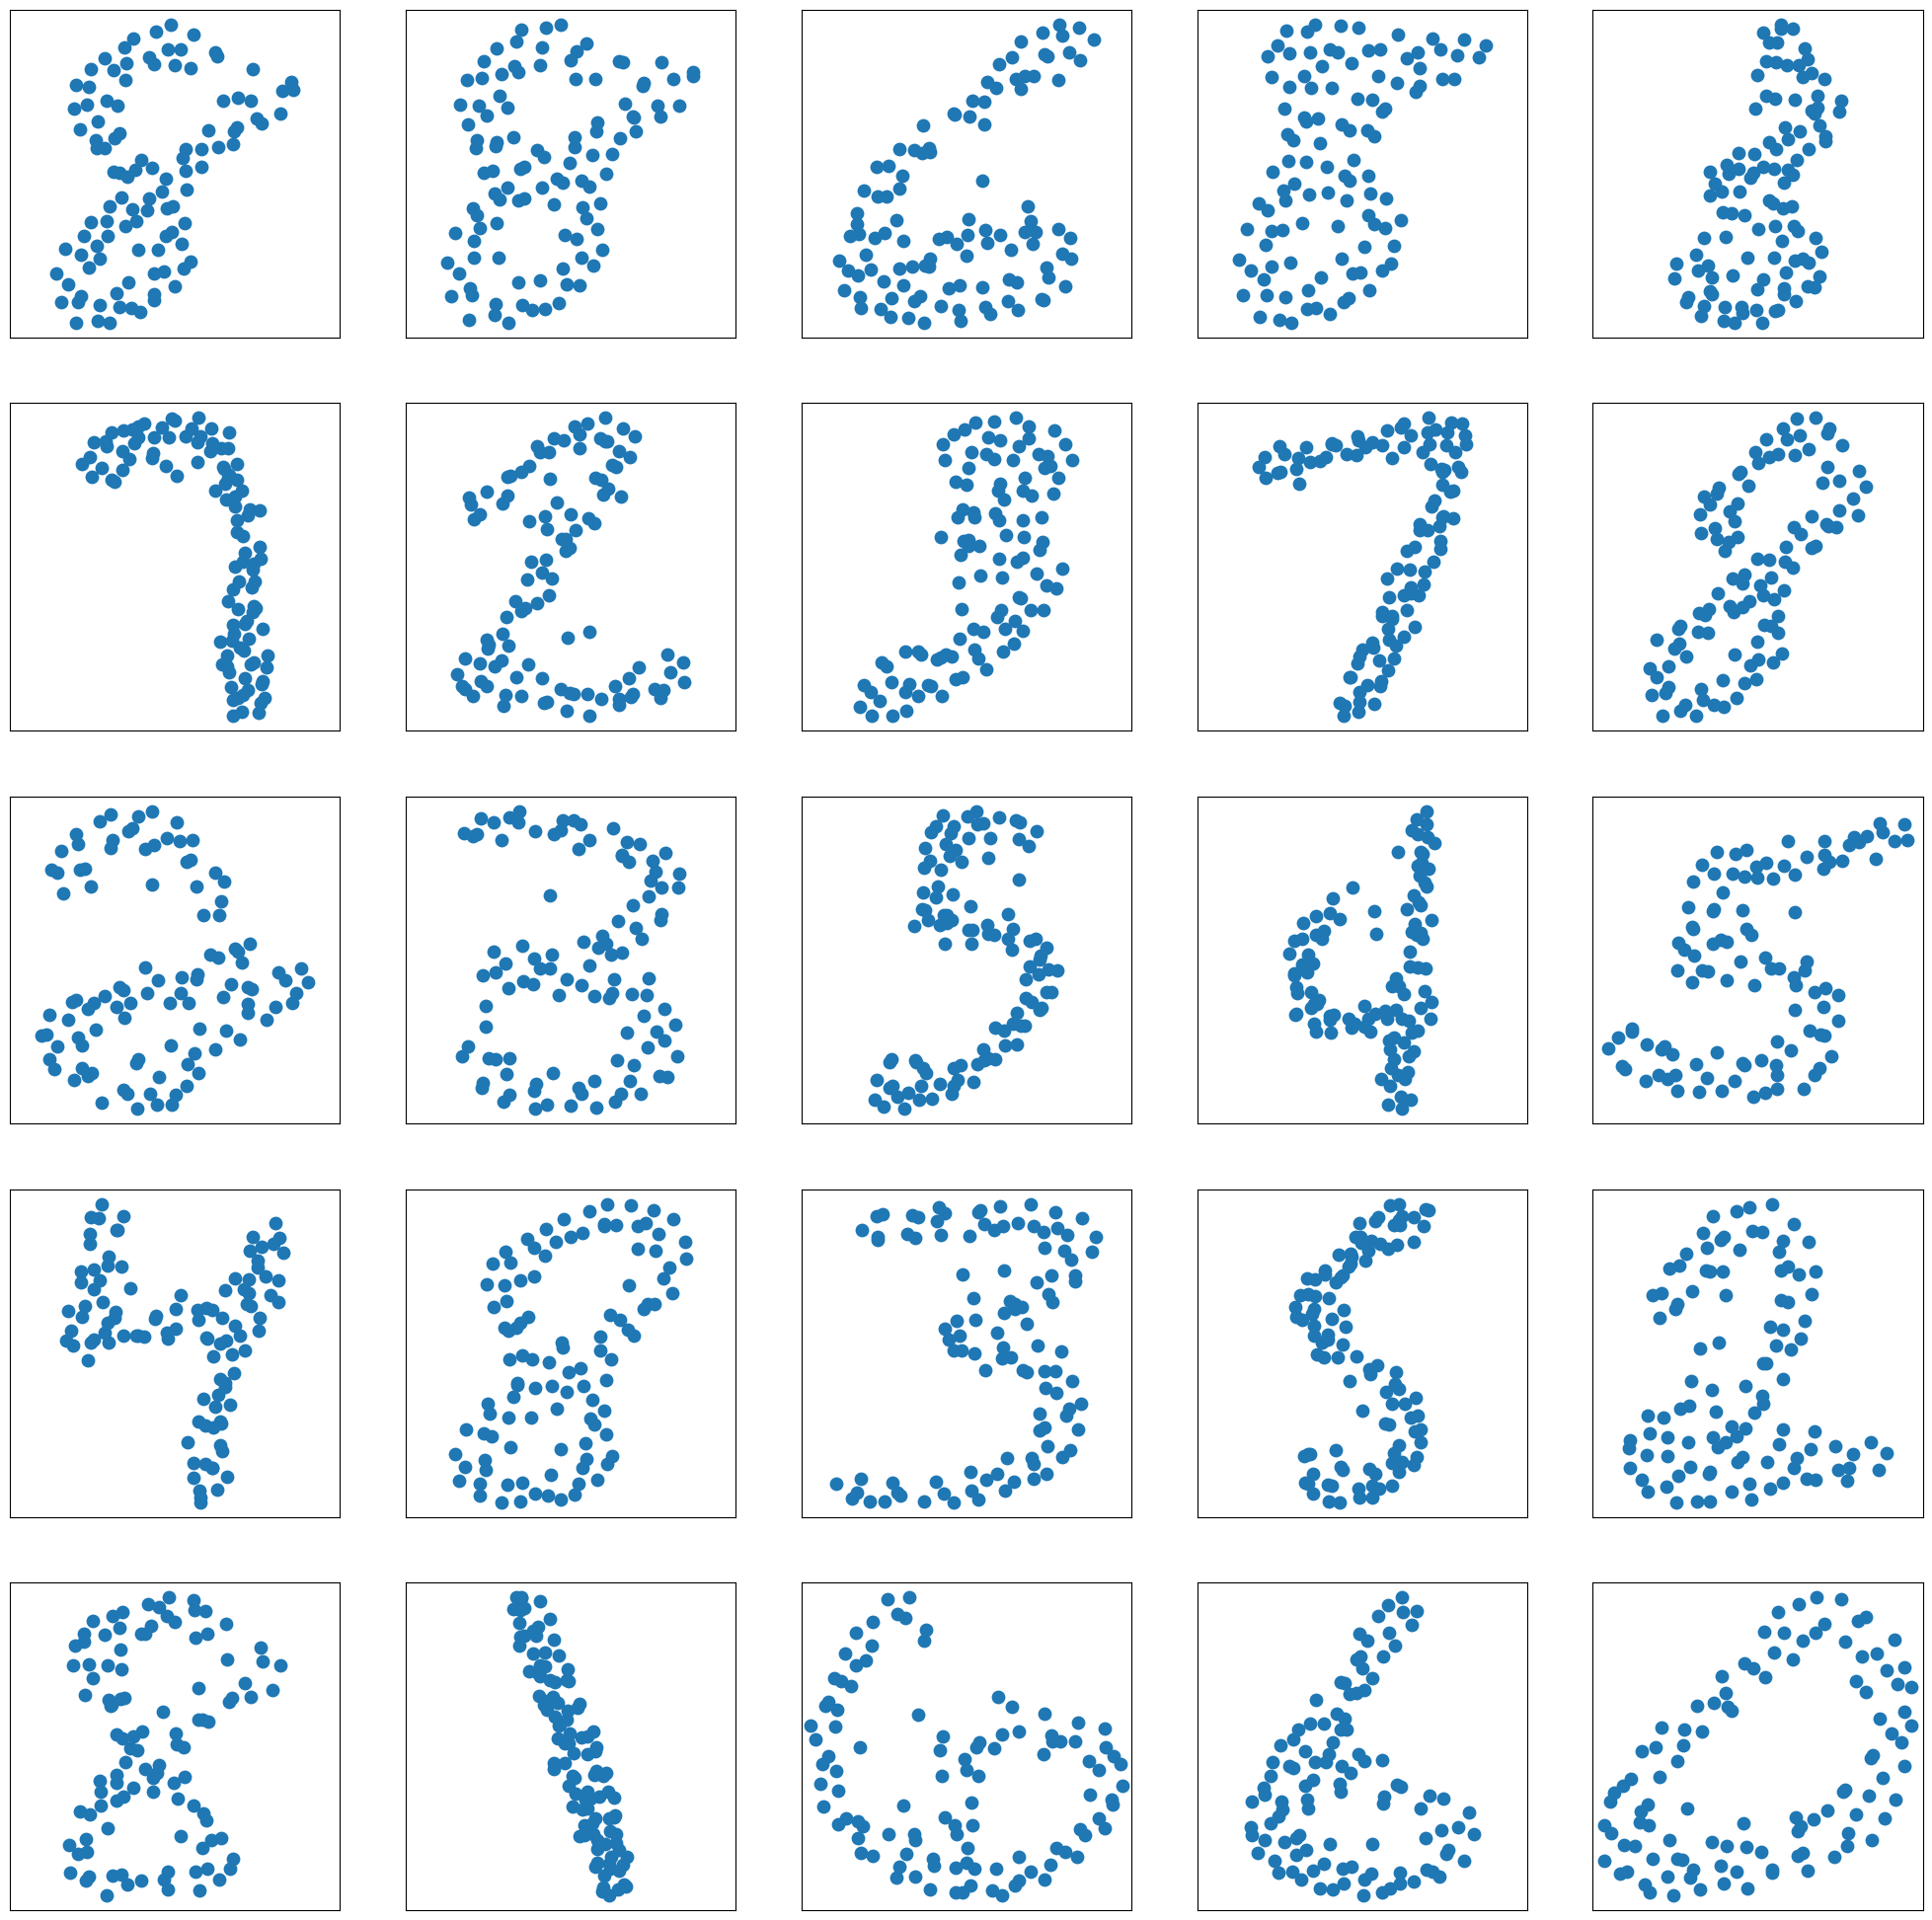

In [17]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(train_decodings)))
    min_val =thresh
    
    plt.subplot(5,5,1+_)
    plt.scatter(train_decodings[ind][:, 1], -train_decodings[ind][:, 0], s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

## Plot test

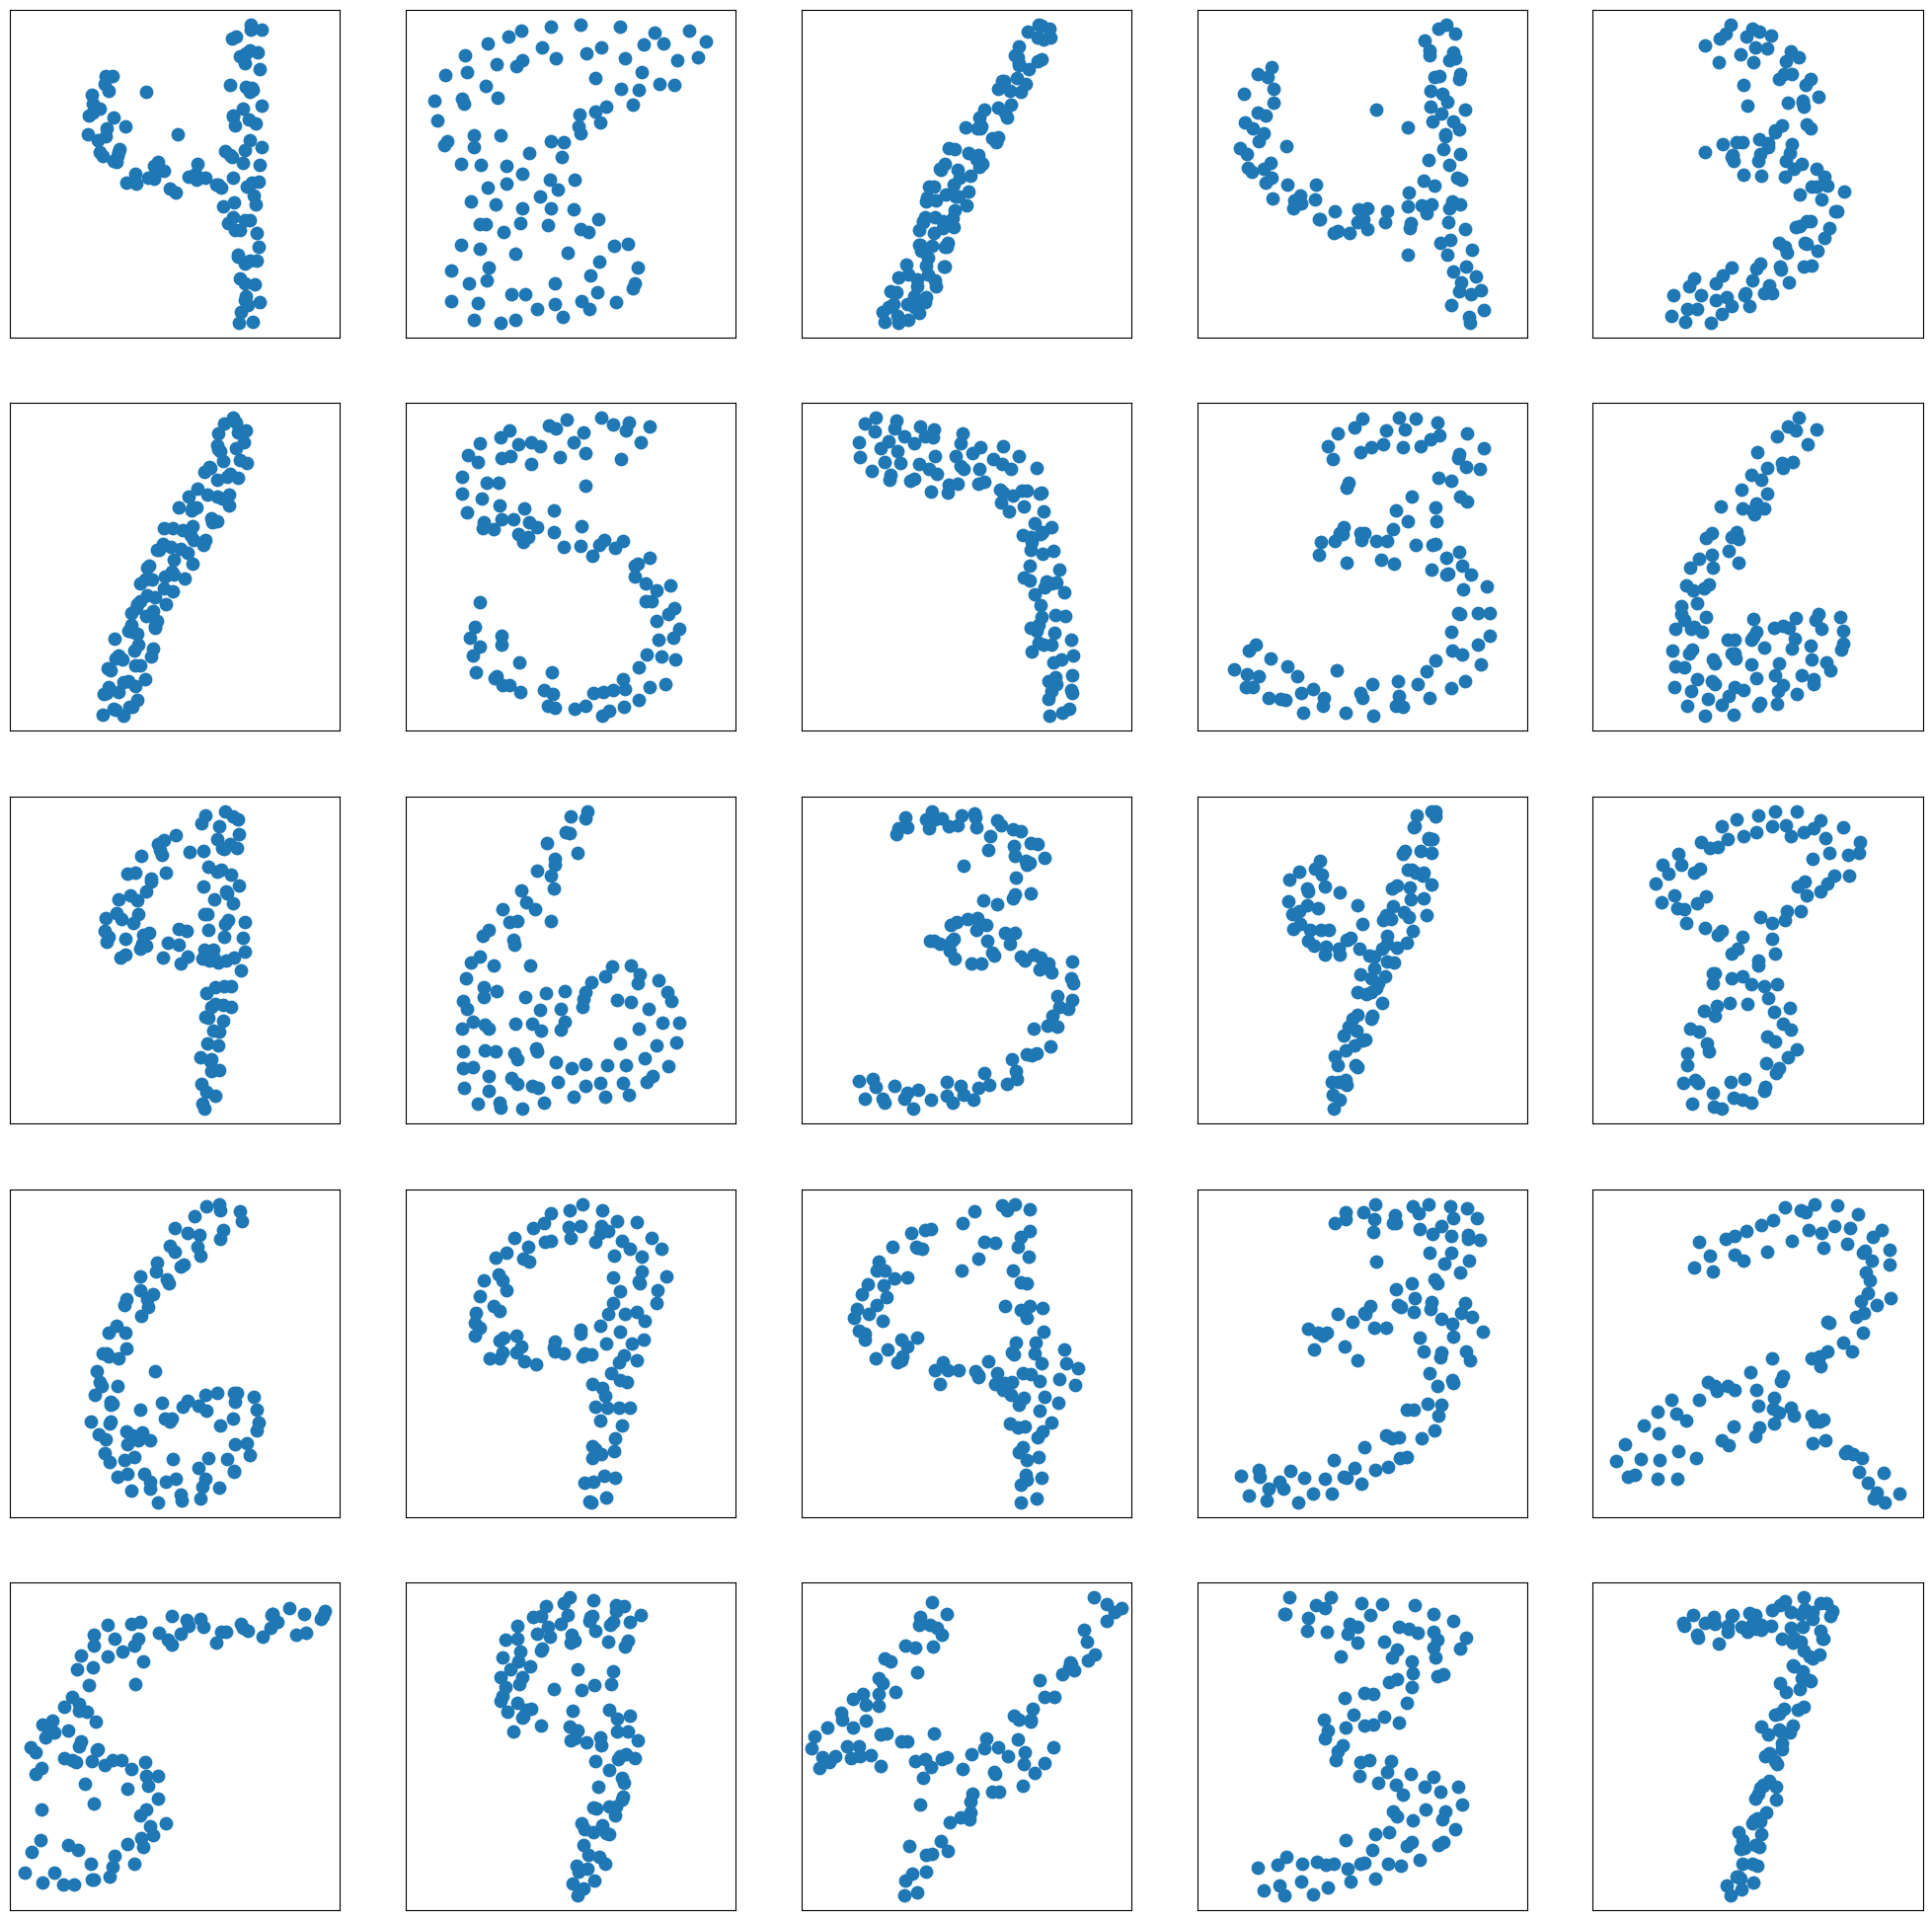

In [18]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(test_decodings)))
    min_val =thresh
    
    plt.subplot(5,5,1+_)
    plt.scatter(test_decodings[ind][:, 1], -test_decodings[ind][:, 0], s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

## Barycenters

### Calculate per-class encoding mean

In [19]:
class_encoding_mean = np.asarray([np.mean(train_encodings[label_train == digit], axis = 0) for digit in list(set(label_train))])

### Decode for Wasserstein barycenters

In [20]:
class_barycenters = WormholeModel.decode(class_encoding_mean)

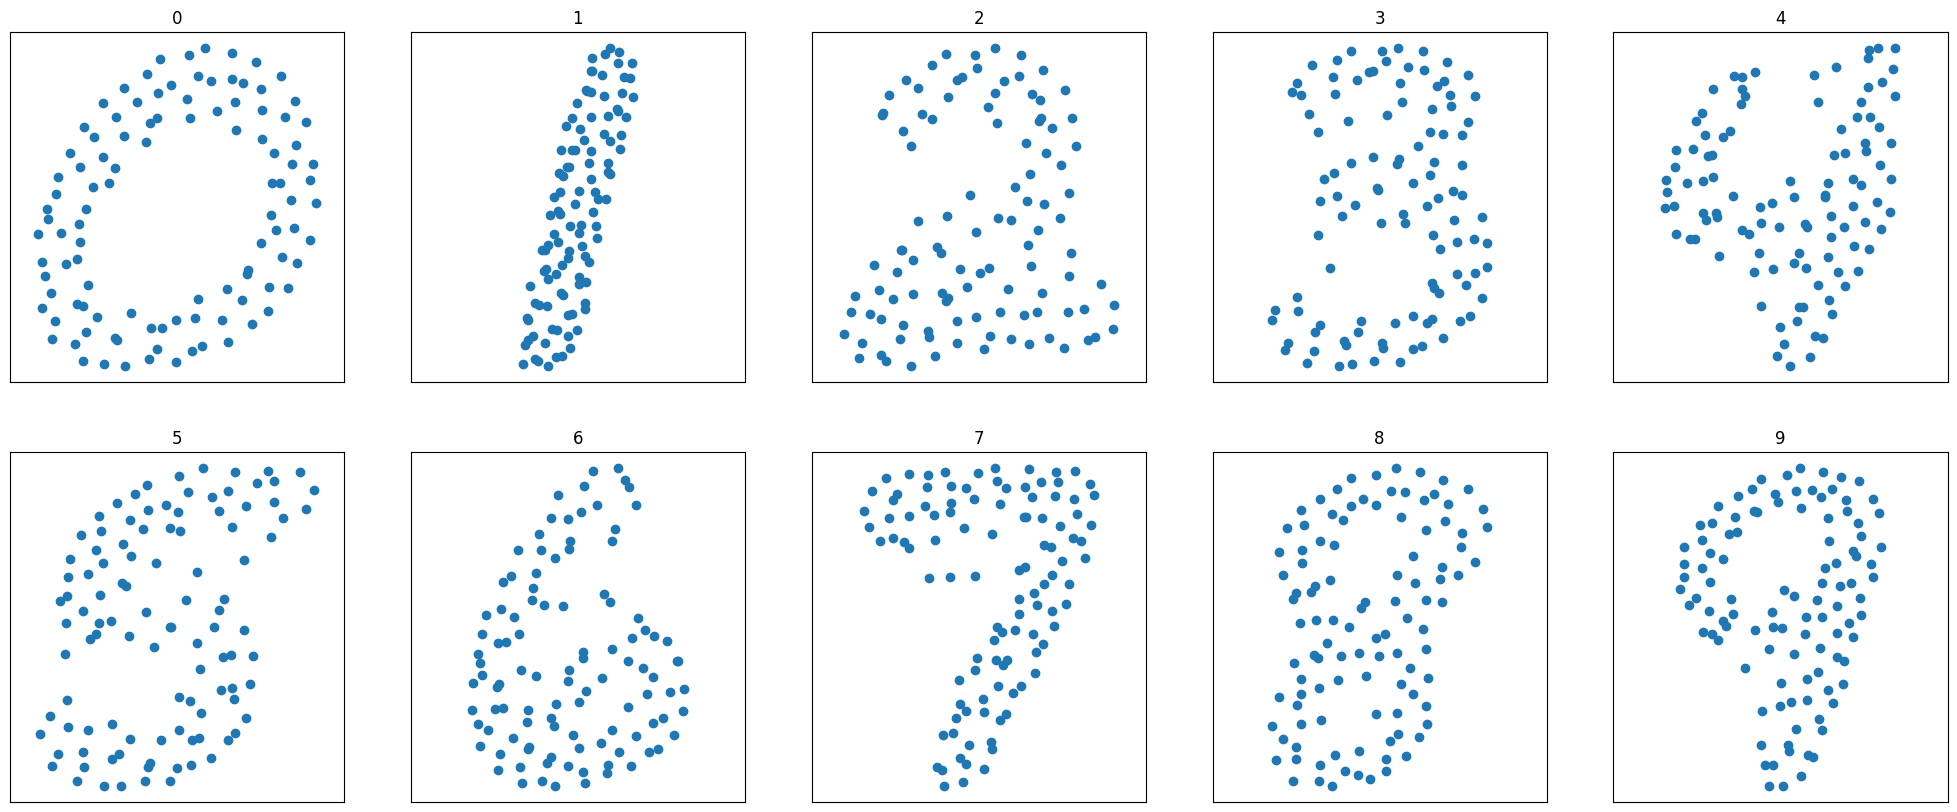

In [21]:
fig = plt.figure(figsize=(25, 10))
for i in list(set(label_train)):
    
    plt.subplot(2,5,1+i)
    plt.scatter(class_barycenters[i][:, 1], -class_barycenters[i][:, 0])
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(i)
plt.show()


## Point Cloud Interpolation

### Chooce start and end encodings

In [22]:
start_ind = np.random.randint(train_encodings.shape[0])
end_ind = np.random.randint(train_encodings.shape[0])

start_enc = train_encodings[start_ind]
end_enc = train_encodings[end_ind]


### Linearly interpolate between them

In [23]:
interpolated_encodings = np.linspace(start_enc, end_enc, 8)

### Decode interpolations

In [24]:
interpolated_decodings = WormholeModel.decode(interpolated_encodings)

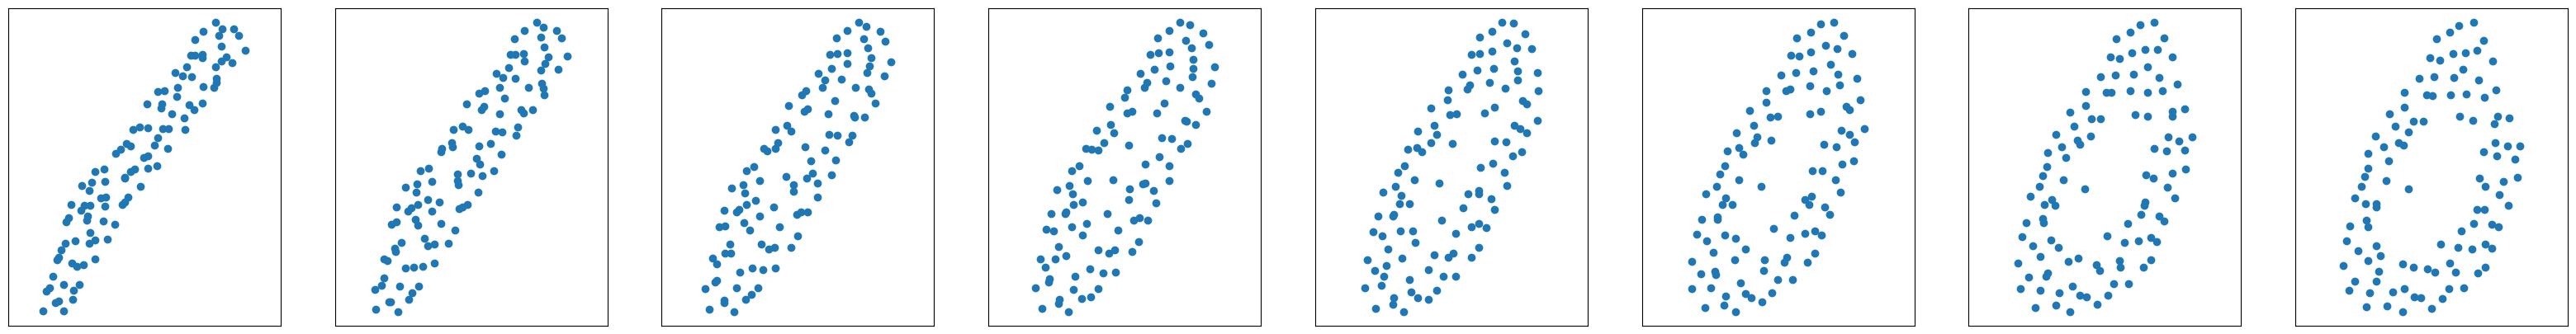

In [25]:
fig = plt.figure(figsize=(interpolated_decodings.shape[0]*5, 5))

    
for i in range(interpolated_decodings.shape[0]):
    
    plt.subplot(1,interpolated_decodings.shape[0],1+i)
    plt.scatter(interpolated_decodings[i][:, 1], -interpolated_decodings[i][:, 0])
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
plt.show()

# Draw UMAPs

In [26]:
fit = umap.UMAP(
    n_neighbors = 30,
    min_dist = 0.01,
    n_components = 2,
)

umap = fit.fit_transform(np.concatenate([train_encodings, test_encodings], axis = 0))
umap_train =  umap[:train_encodings.shape[0]] 
umap_test =  umap[train_encodings.shape[0]:] 

In [27]:
cat_cmap = matplotlib.cm.get_cmap('cet_glasbey')
label_palette = {ctype:cat_cmap(i) for i,ctype in enumerate(list(set(label_train)))}

/tmp/ipykernel_31018/2627742441.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cat_cmap = matplotlib.cm.get_cmap('cet_glasbey')


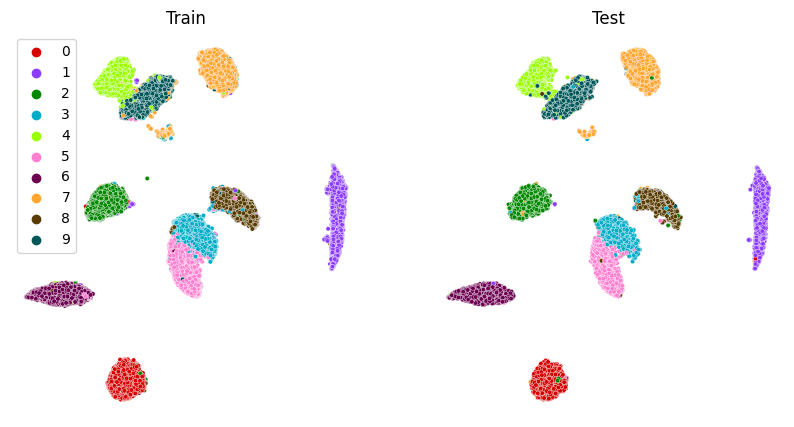

In [28]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x = umap_train[:, 0], 
                y = umap_train[:, 1], legend = True,
                hue = label_train, 
                s = 10, palette = label_palette)
plt.axis('off')
plt.title("Train")

plt.subplot(122 )
sns.scatterplot(x = umap_test[:, 0], 
                y = umap_test[:, 1], legend = False,
                hue = label_test, 
                s = 10, palette = label_palette)
plt.axis('off')
plt.title("Test")
plt.show()

# Classify Digits

In [29]:
classifier = sklearn.neural_network.MLPClassifier(max_iter=1000).fit(train_encodings, label_train)
test_predictions = classifier.predict(test_encodings)

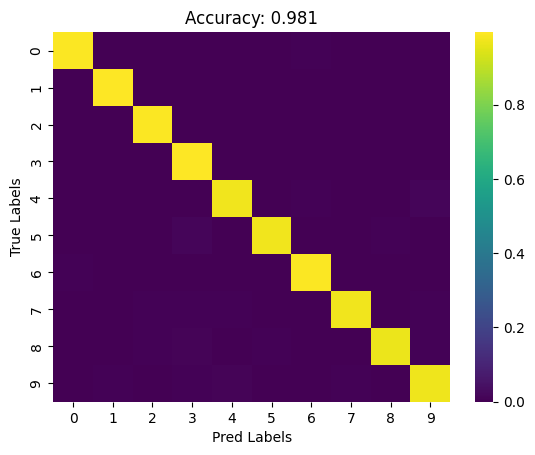

In [30]:
cm = pd.DataFrame(sklearn.metrics.confusion_matrix(label_test, test_predictions, labels=classifier.classes_, normalize = 'true'),
                  index = classifier.classes_, columns = classifier.classes_,)
sns.heatmap(cm, cmap = 'viridis')
plt.ylabel("True Labels")
plt.xlabel("Pred Labels")
plt.title("Accuracy: " + str(round(np.mean(label_test == test_predictions), 3)))
plt.show()